# Modelo de regresión usando redes neuronales para la identificación de edad en fotografías de personas

**Tabla de contenidos**

* [Descripción del proyecto](#intro) 
* [Inicializacion](#initialization)
* [Cargar datos](#data_loading)
* [Análsis Exploratorio de Datos](#eda)
* [Modelado](#modelling)
* [Conclusiones](#conclusions)

# Descripción del proyecto <a name="intro"></a>

A la cadena de supermercados Good Seed le gustaría explorar si la ciencia de los datos puede ayudarle a cumplir con las leyes sobre el alcohol, al asegurarse de no vender alcohol a personas menores de edad. En este proyecto se tuvo en cuenta lo siguiente:

* Las tiendas están equipadas con cámaras en el área de pago, las cuales se activan cuando una persona está comprando alcohol.

* Los métodos de visión artificial se pueden usar para determinar la edad de una persona a partir de una foto.

* Para empezar a trabajar en la tarea, se contó con un conjunto de fotografías de personas que indican su edad.

En ese sentido, se construyó y evaluó un modelo para verificar la edad de las personas.

## Inicialización

In [2]:
# Importa librerías para la sección de EDA

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Cargar datos <a name="data_loading"></a>      

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
labels.duplicated().sum()

0

In [7]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [8]:
def load_train(path): 
    
    """
    Carga las imágenes usando el
    generados de datos de keras
    """
    
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

    return train_gen_flow

train_gen_flow = load_train('/datasets/faces/final_files/')
train_gen_flow

Found 7591 validated image filenames.


**Conclusiones intermedias**

1. El conjunto de datos cuenta con 7591 imágenes.
2. No existen valores ausentes o duplicados.
3. El rango de edad de las personas en la base de datos de las fotografías va de 1 a 100 años. La edad promedio es de 31 años.

## EDA <a name="eda"></a>

Text(0, 0.5, 'Frequency')

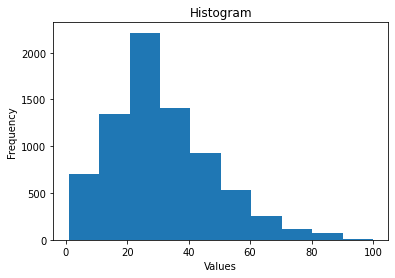

In [9]:
# Distribución de los datos de edas de las personas en las fotografías

labels['real_age'].plot(kind='hist')
plt.title('Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')

In [10]:
# Genera una lista con los nombres de los  
# archivos de imágenes y su ubicación

path = '/datasets/faces/final_files/'
file_names = (labels['file_name'].iloc[0:8]).tolist()
directory_names = [path + name for name in file_names ]

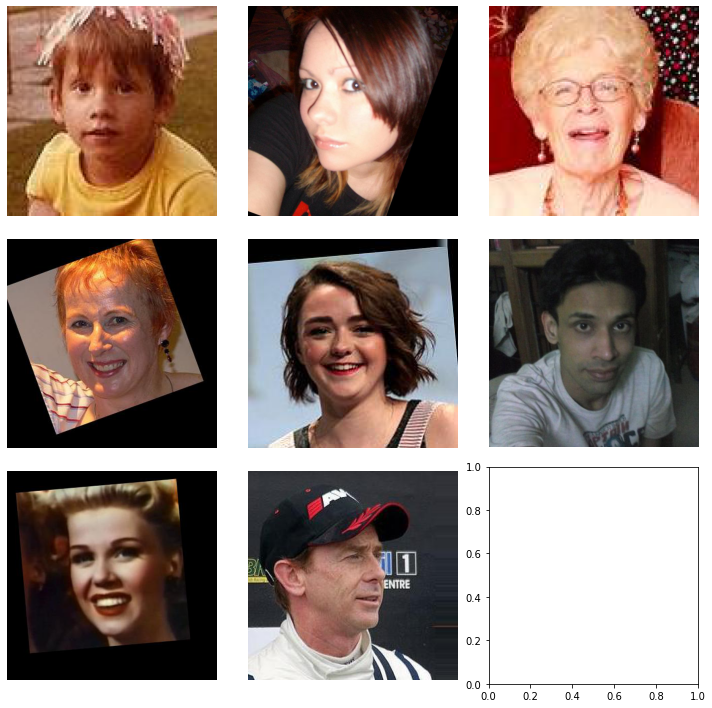

In [11]:
# Extrae la extesión de la lista de nombres de directorios
num_images = len(directory_names)

# Calcula el número de filas y columnas de los subgráficos
num_rows = int(num_images / 3) + 1
num_cols = min(num_images, 3)

# Crea subgráficos
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Itera sobre los nombres de los archivos y grafica las imágenes
for i, file_name in enumerate(directory_names):
    # Abre el archivo usando la librería PIL
    image = Image.open(file_name)

    # Determina el índice del subgráfico
    row = i // num_cols
    col = i % num_cols

    # Grafica la imágen en el correspondiente subgráfico
    axes[row, col].imshow(image)
    axes[row, col].axis('off')

# Ajusta la presentación de los subgráficos
plt.tight_layout()

# Muestra los gráficos
plt.show()

**Conclusiones intermedias**

1.- El histograma refleja que la mayor parte de las fotografías corresponden a personas entre 18 y 50 años. En ese sentido, los datos son representativos del problema que se quiere investigar. 

2.- Las fotografías tienen diferentes resoluciones, variaciones de brillo,contraste, rotaciones, tecnología de captura, etc. Todo esto podría afectar al modelo.

3.- No existen sesgos de edad en los datos, sin embargo en base a este análisis inicial, no se puede saber si existen otro tipo de sesgos en la conjunto de datos. Por ejemplo, de determinadas razas o sexos.   

## Modelado <a name="modelling"></a>

In [12]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [13]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    df = pd.read_csv(path + 'labels.csv')
    img_dir = path + 'final_files/'
    # coloca tu código aquí
    train_gen = ImageDataGenerator(
                            validation_split=0.2,
                            rescale=1/255.,
                            horizontal_flip=True,
                            width_shift_range=.2,
                            zoom_range=0.2,
    )
    train_gen_flow = train_gen.flow_from_dataframe(
                            df,
                            directory=img_dir,
                            x_col='file_name',
                            y_col='real_age',
                            target_size=(224, 224),
                            batch_size=32,
                            class_mode='raw',
                            subset='training',
                            seed=42,
                            )

    return train_gen_flow

In [14]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    df = pd.read_csv(path +'labels.csv')
    img_dir = path + 'final_files/'
    #  coloca tu código aquí
    test_gen = ImageDataGenerator(
                            validation_split=0.2,
                            rescale=1/255.,
    )
    test_gen_flow = test_gen.flow_from_dataframe(
                            df,
                            directory=img_dir,
                            x_col='file_name',
                            y_col='real_age',
                            target_size=(224, 224),
                            batch_size=32,
                            class_mode='raw',
                            subset='validation',
                            seed=42,
                            )

    return test_gen_flow


In [15]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    
    #  coloca tu código aquí

    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(lr=0.0001) 
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model


In [16]:
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    #  coloca tu código aquí

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True,
    )

    return model


### Prepara el script para ejecutarlo en la plataforma GPU

In [17]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Resultado

Los resultados de la corrida en la plataforma GPU se muestran a continuación: 

Train for 190 steps, validate for 48 steps
Epoch 1/5
190/190 - 124s - loss: 245.8459 - mae: 11.2099 - val_loss: 664.2037 - val_mae: 20.6802

Epoch 2/5
190/190 - 97s - loss: 87.3943 - mae: 7.1064 - val_loss: 702.5042 - val_mae: 21.4021

Epoch 3/5
190/190 - 97s - loss: 67.8905 - mae: 6.3130 - val_loss: 430.0824 - val_mae: 16.1761

Epoch 4/5
190/190 - 97s - loss: 52.9952 - mae: 5.5808 - val_loss: 94.6739 - val_mae: 7.4270

Epoch 5/5
190/190 - 97s - loss: 45.9932 - mae: 5.2213 - val_loss: 81.5969 - val_mae: 6.7576
48/48 - 8s - loss: 81.5969 - mae: 6.7576

Test MAE: 6.7576

## Conclusiones <a name="conclusions"></a>

1. El resultado final del modelo fue de un MAE un poco menor a 7 años. Este es un resultado aceptable de acuerdo a las especificaciones del proyecto. La configuración del modelo que dió este resultado fue: 

            * red neuronal con arquitectura ResNet50 
            * optimizador Adam con tasa de aprendizaje 0.0001
            * lotes de carga de 32 imágenes
            * corrida de 5 épocas 

2. A pesar de que las guías del proyecto consideren como resultado aceptable un valor de MAE menor a 7, el modelo no sería de utilidad para el cliente puesto que el mismo necesita saber si una persona menor de edad está intentanto comprar alcohol. Con un error absoluto medio de 7 años el modelo podría cometer errores muy evidentes. Tal vez se lo podría usar como una referencia. En ese sentido, cabe recalcar que el uso de esta métrica, en este caso particular es imprescindible.     

3. En virtud de que el modelo para el uso de verificación de edad sería solo referencial, el mismo podría tener otras aplicaciones para una licorería como por ejemplo para campañas de marketing o la analítica de ventas. 

# Lista de revisión

- [x]  El Notebook estaba abierto 
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución
- [x]  Se realizó el análisis exploratorio de datos
- [x]  Los resultados del análisis exploratorio de datos se presentan en el notebook final
- [x]  El valor EAM del modelo no es superior a 8
- [x]  El código de entrenamiento del modelo se copió en el notebook final
- [x]  El resultado de entrenamiento del modelo se copió en el notebook final
- [x]  Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo